In [1]:
import os
import json
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, Dropout, BatchNormalization, Flatten, MaxPool1D, GlobalAveragePooling1D, Multiply
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
tf.random.set_seed(123)

### Load dataset

In [4]:
x_train_path = '/gdrive/MyDrive/dataset-460-40/x/'
y_train_path = '/gdrive/MyDrive/dataset-460-40/y/'
x_test_path = '/gdrive/MyDrive/dataset-460-40/x_test/'
y_test_path = '/gdrive/MyDrive/dataset-460-40/y_test/'

x_train_jsons = glob(x_train_path+'*.json')
y_train_jsons = glob(y_train_path+'*.json')
x_test_jsons = glob(x_test_path+'*.json')
y_test_jsons = glob(y_test_path+'*.json')

x_train_jsons.sort()
y_train_jsons.sort()
x_test_jsons.sort()
y_test_jsons.sort()

In [5]:
x_train = []
y_train = []
x_test = []
y_test = []

for file in x_train_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    x_train.append(cords)

for file in y_train_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    y_train.append(cords)
    
for file in x_test_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    x_test.append(cords)

for file in y_test_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    y_test.append(cords)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

460
460
40
40


In [6]:
# Find max length of sequence
max_dim = 0
for x in x_train:
    dim, _ = x.shape
    if dim>max_dim:
        max_dim=dim

for x in x_test:
    dim, _ = x.shape
    if dim>max_dim:
        max_dim=dim

print(max_dim)

267


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

### Padding/mask creation

In [8]:
X_train = np.zeros((len(x_train), max_dim, 2))
X_test = np.zeros((len(x_test), max_dim, 2))
X_valid = np.zeros((len(x_valid), max_dim, 2))

Y_train = np.zeros((len(y_train), max_dim))
Y_test = np.zeros((len(y_test), max_dim))
Y_valid = np.zeros((len(y_valid), max_dim))


X_train_mask = np.zeros((len(y_train), max_dim))
X_test_mask = np.zeros((len(y_test), max_dim))
X_valid_mask = np.zeros((len(y_valid), max_dim))


for i,x in enumerate(x_train):
    dim, _ = x.shape
    X_train[i,:dim,:] = x
    X_train[i,dim:,:] = 500 #set dummy values as 500

    X_train_mask[i,:dim] = 1
    X_train_mask[i,dim:] = 0

    Y_train[i,:dim] = y_train[i]
    Y_train[i,dim:] = 0  #set padding as "0"


for i,x in enumerate(x_test):
    dim, _ = x.shape
    X_test[i,:dim,:] = x
    X_test[i,dim:,:] = 500 #set dummy values as 500

    X_test_mask[i,:dim] = 1
    X_test_mask[i,dim:] = 0

    Y_test[i,:dim] = y_test[i]
    Y_test[i,dim:] = 0 #set padding as "0"


for i,x in enumerate(x_valid):
    dim, _ = x.shape
    X_valid[i,:dim,:] = x
    X_valid[i,dim:,:] = 500 #set dummy values as 500

    X_valid_mask[i,:dim] = 1
    X_valid_mask[i,dim:] = 0

    Y_valid[i,:dim] = y_valid[i]
    Y_valid[i,dim:] = 0 #set padding as "0"


### X-mask check

In [ ]:
# for a,b in zip(X_train[0],X_train_mask[0]):
#     print(a,b)

### Input-Output shapes

In [9]:
print(X_train.shape, X_train_mask.shape, Y_train.shape)
print(X_test.shape, X_test_mask.shape, Y_test.shape)
print(X_valid.shape, X_valid_mask.shape, Y_valid.shape)

(414, 267, 2) (414, 267) (414, 267)
(40, 267, 2) (40, 267) (40, 267)
(46, 267, 2) (46, 267) (46, 267)


### Model creation

In [10]:
inp = Input(shape=(max_dim,2))
#mask = Input(shape=(max_dim,))

c11 = Conv1D(32,3,activation='relu',padding='same')(inp)
b1 = BatchNormalization()(c11)
d1 = Dropout(0.2)(b1)
c12 = Conv1D(32,3,activation='relu',padding='same')(d1)
b2 = BatchNormalization()(c12)
p1 = MaxPool1D(2)(b2)

c21 = Conv1D(64,3,activation='relu',padding='same')(p1)
b3 = BatchNormalization()(c21)
d2 = Dropout(0.2)(b3)
c22 = Conv1D(64,3,activation='relu',padding='same')(d2)
b4 = BatchNormalization()(c22)
p2 = MaxPool1D(2)(b4)

c31 = Conv1D(128,3,activation='relu',padding='same')(p2)
b5 = BatchNormalization()(c31)
d3 = Dropout(0.2)(b5)
c32 = Conv1D(128,3,activation='relu',padding='same')(d3)
b6 = BatchNormalization()(c32)
p3 = MaxPool1D(2)(b6)

c41 = Conv1D(256,3,activation='relu',padding='same')(p3)
b7 = BatchNormalization()(c41)
d4 = Dropout(0.2)(b7)
c42 = Conv1D(256,3,activation='relu',padding='same')(d4)
b8 = BatchNormalization()(c42)

flat = GlobalAveragePooling1D()(b8)

dense = Dense(512, activation='relu')(flat)
drop = Dropout(0.2)(dense)

out = Dense(max_dim, activation='sigmoid')(drop) 
#output_with_mask=Multiply()([out, mask])

model = Model(inputs=inp, outputs=out)
#model = Model(inputs=[inp,mask], outputs=[output_with_mask])

### Model summary

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 267, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 267, 32)           224       
_________________________________________________________________
batch_normalization (BatchNo (None, 267, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 267, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 267, 32)           3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 267, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 133, 32)           0     

### Model graph

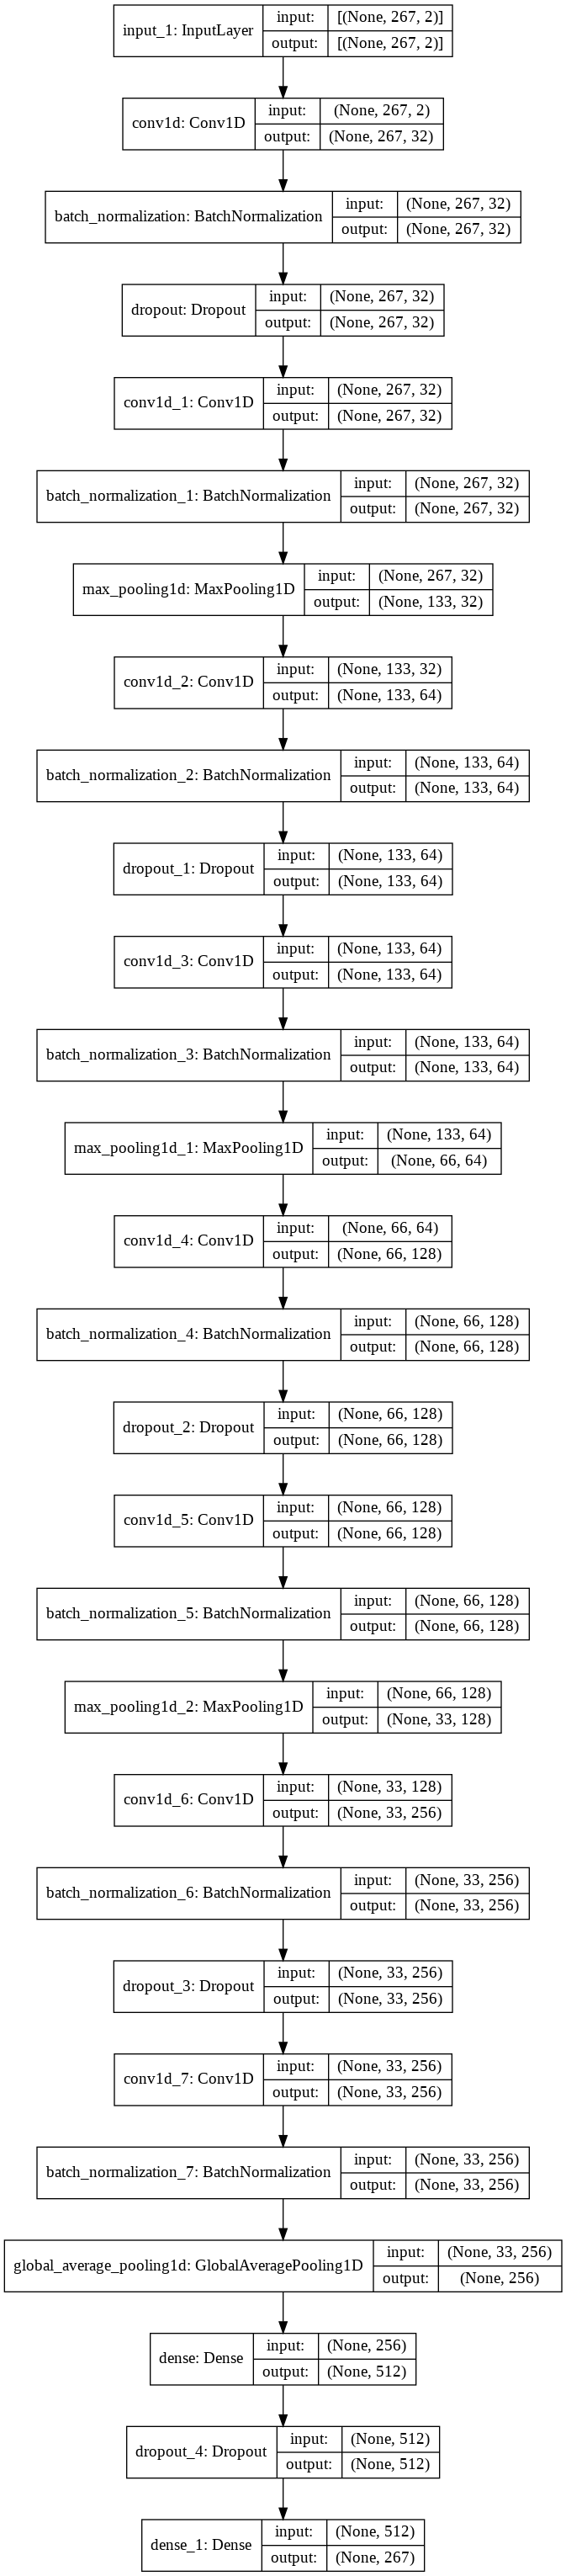

In [12]:
tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True)


### Metrics

In [12]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [13]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    
    return 1 - K.mean(f1)

### Compile

In [14]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=15, min_lr=0.001)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)
loss = tf.keras.losses.BinaryCrossentropy()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=15, mode='max', restore_best_weights=True, verbose=1)
model.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])
#model.compile(loss=loss, optimizer=optimizer, metrics=[Precision, Recall, F1Score])

### Train

In [15]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), epochs=200, batch_size=32, callbacks=[early_stop])
#history = model.fit(x=[X_train,X_train_mask], y=Y_train, validation_data= ([X_valid,X_valid_mask] ,Y_valid), epochs=200, batch_size=32, callbacks=[early_stop])

Epoch 1/200
13/13 [==============================] - 6s 226ms/step - loss: 0.6661 - acc: 0.0000e+00 - precision: 0.2815 - recall: 0.5152 - f1: 0.2169 - val_loss: 0.5583 - val_acc: 0.0000e+00 - val_precision: 0.3751 - val_recall: 0.4136 - val_f1: 0.1032
Epoch 2/200
13/13 [==============================] - 2s 162ms/step - loss: 0.5633 - acc: 0.0604 - precision: 0.4931 - recall: 0.5268 - f1: 0.2145 - val_loss: 0.3736 - val_acc: 1.0000 - val_precision: 0.4948 - val_recall: 0.3841 - val_f1: 0.0933
Epoch 3/200
13/13 [==============================] - 2s 169ms/step - loss: 0.4438 - acc: 0.2222 - precision: 0.5792 - recall: 0.5143 - f1: 0.1981 - val_loss: 0.3278 - val_acc: 1.0000 - val_precision: 0.5254 - val_recall: 0.3713 - val_f1: 0.0903
Epoch 4/200
13/13 [==============================] - 2s 159ms/step - loss: 0.3760 - acc: 0.3478 - precision: 0.5868 - recall: 0.5207 - f1: 0.2021 - val_loss: 0.4697 - val_acc: 1.0000 - val_precision: 0.4798 - val_recall: 0.5373 - val_f1: 0.1466
Epoch 5/200


In [16]:
model.evaluate(X_test,Y_test)
#model.evaluate([X_test,X_test_mask],Y_test)

2/2 [==============================] - 0s 18ms/step - loss: 0.3227 - acc: 0.9750 - precision: 0.5619 - recall: 0.7761 - f1: 0.3522


[0.3227309286594391,
 0.9750000238418579,
 0.5618695616722107,
 0.7761263251304626,
 0.35216906666755676]

dict_keys(['loss', 'acc', 'precision', 'recall', 'f1', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])


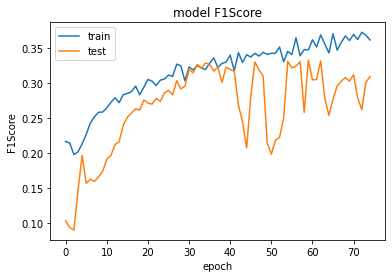

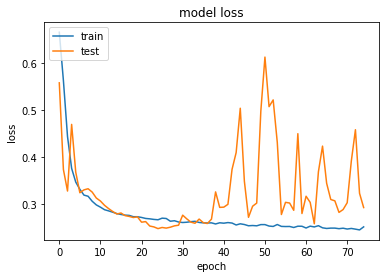

In [17]:
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# print(history.history.keys())
# # summarize history for F1Score
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model acc')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

###Evaluate with test sample

In [18]:
pred = model.predict(X_test)
#pred = model.predict([X_test,X_test_mask])

In [19]:
pred = np.round(pred)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [21]:
matrix = confusion_matrix(Y_test.flatten(), pred.flatten(), labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(Y_test.flatten(), pred.flatten(), labels=[0,1]))

Confusion matrix : 
 [[7224 1303]
 [ 482 1671]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      8527
           1       0.56      0.78      0.65      2153

    accuracy                           0.83     10680
   macro avg       0.75      0.81      0.77     10680
weighted avg       0.86      0.83      0.84     10680



###Confusion Matrix (excluding padding)

In [22]:
prediction = list()
for i in range(len(y_test)):
  length = y_test[i].shape[0]
  individual_pred = pred[i][:length]
  individual_pred = list(individual_pred)
  prediction.extend(individual_pred)

In [23]:
truth = list()
for i in range(len(y_test)):
  length = y_test[i].shape[0]
  individual_truth = Y_test[i][:length]
  individual_truth = list(individual_truth)
  truth.extend(individual_truth)

In [24]:
matrix = confusion_matrix(truth, prediction, labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1]))

Confusion matrix : 
 [[ 515 1136]
 [ 482 1671]]
              precision    recall  f1-score   support

           0       0.52      0.31      0.39      1651
           1       0.60      0.78      0.67      2153

    accuracy                           0.57      3804
   macro avg       0.56      0.54      0.53      3804
weighted avg       0.56      0.57      0.55      3804



###Examine single test sample

In [25]:
Y_predict= model.predict([np.expand_dims(X_test[0],axis=0)])
#Y_predict= model.predict([np.expand_dims(X_test[1],axis=0),np.expand_dims(X_test_mask[1],axis=0)])

In [26]:
Y_predict = np.round(Y_predict)

In [27]:
Y_predict

array([[1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [28]:
Y_test[0]

array([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.